#Downloading the Dataset

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f"User uploaded file {fn} with length {len(uploaded[fn])}")

#Move kaggle.json into the folder where the API expects to find it
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file kaggle.json with length 69


In [2]:
!kaggle datasets download -d shawon10/ckplus

  0% 0.00/3.63M [00:00<?, ?B/s]
100% 3.63M/3.63M [00:00<00:00, 111MB/s]


In [3]:
import zipfile
file_name = "/content/ckplus.zip"
with zipfile.ZipFile(file_name,"r") as zip_ref:
  zip_ref.extractall()
  print(f"Done")

Done


In [4]:
import os
os.listdir("CK+48")

['happy', 'sadness', 'surprise', 'disgust', 'anger', 'contempt', 'fear']

creating train and test directories

In [5]:
from sklearn.model_selection import train_test_split
import shutil
dataset_dir = "CK+48"

train_dir = "train"
test_dir = "test"

os.makedirs(train_dir,exist_ok = True)
os.makedirs(test_dir , exist_ok = True)

for label in os.listdir(dataset_dir):
  class_dir = os.path.join(dataset_dir,label)

  train_label_dir = os.path.join(train_dir,label)
  test_label_dir = os.path.join(test_dir,label)
  os.makedirs(train_label_dir , exist_ok = True)
  os.makedirs(test_label_dir , exist_ok = True)

  file_names = os.listdir(class_dir)

  train_files , test_files = train_test_split(file_names , test_size = 0.2)

  for file_name in train_files:
    src_path = os.path.join(class_dir , file_name)
    dst_path = os.path.join(train_label_dir,file_name)
    shutil.copy(src_path,dst_path)

  for file_name in test_files:
    src_path = os.path.join(class_dir,file_name)
    dst_path = os.path.join(test_label_dir,file_name)
    shutil.copy(src_path,dst_path)

Visualizing an Image

Image label : anger
Image size : (48, 48)


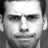

In [6]:
import random
from PIL import Image
random.seed(42)
import random
from pathlib import Path
image_path = Path("train/")

image_path_list = list(image_path.glob("*/*/"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem


img = Image.open(random_image_path)

print(f"Image label : {image_class}")
print(f"Image size : {img.size}")
img


Converting to Numpy for Visualization in matplotlib

(-0.5, 47.5, 47.5, -0.5)

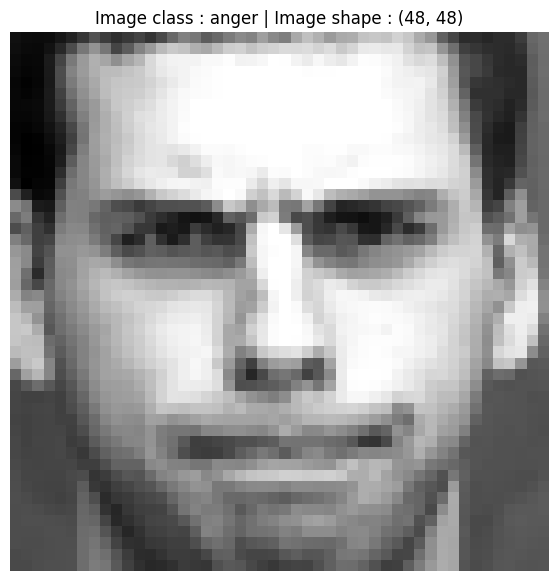

In [7]:
import matplotlib.pyplot as plt
import numpy as np

img_as_array = np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(img_as_array,cmap = "gray")
plt.title(f"Image class : {image_class} | Image shape : {img_as_array.shape}")
plt.axis("off")

In [8]:
import torch
import torch.nn as nn

#Creating TinyVGG Model

In [114]:
class TinyVGG(nn.Module):
  def __init__(self,input_shape,
               hidden_units,output_shape):
    super().__init__()
    self.conv_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3, stride = 1 , padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3 , stride = 1 , padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2 , stride = 1),
    )

    self.conv_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3 , stride = 1 , padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3 , stride = 1 , padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2 , stride = 2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 729,
                  out_features = output_shape),
    )

  def forward(self,x):
    x = self.conv_1(x)
    x = self.conv_2(x)
    x = self.classifier(x)
    return x

In [106]:
def find_classes(directory):
  #Finds the class folder names in a target directory
  #Get the class names by scanning the target directory
  classes =  sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  #Create a dictionary of index labels (computer prefer numbers rather than strings as labels)
  class_to_idx = {class_names : i for i,class_names in enumerate (classes)}
  return classes,class_to_idx

In [32]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self,targ_dir,transform):
    self.paths = list(Path(targ_dir).glob("*/*"))

    self.transform = transform

    self.classes , self.class_to_idx = find_classes(targ_dir)

  #Create a function to load images
  def load_images(self,index):
    image_path = self.paths[index]
    return Image.open(image_path)

  #Return the length
  def __len__(self):
    return len(self.paths)

  #__getitem__() method to return a particular sample
  def __getitem__(self,index):
    #Return one sample of data , data and label
    img = self.load_images(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img) , class_idx
    else:
      return img,class_idx


In [33]:
#Create a transform

from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [34]:
train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform = train_transforms)

test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                     transform = test_transforms)

In [35]:
class_names = train_data_custom.classes

In [36]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape = 1,
                  hidden_units = 10,
                  output_shape = len(class_names))

In [37]:
model_0

TinyVGG(
  (conv_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=7290, out_features=7, bias=True)
  )
)

In [38]:
#Turn Datasets into DataLoaders
from torch.utils.data import DataLoader
BATCHES = 32
NUM_WORKERS = os.cpu_count()


train_dataloader = DataLoader(dataset = train_data_custom,
                    batch_size = BATCHES,
                    num_workers = NUM_WORKERS,
                    shuffle = True,)

test_dataloader = DataLoader(dataset = test_data_custom,
                   batch_size = BATCHES,
                   num_workers = NUM_WORKERS,
                   shuffle = True)


In [39]:
image_batch , label_batch = next(iter(train_dataloader))


In [40]:
print(f"Image_batch shape is {image_batch.shape} , Label_batch shape is {label_batch.shape}")

Image_batch shape is torch.Size([32, 1, 64, 64]) , Label_batch shape is torch.Size([32])


In [41]:
class_names = train_data_custom.classes
class_idx = train_data_custom.class_to_idx
class_idx , class_names

({'anger': 0,
  'contempt': 1,
  'disgust': 2,
  'fear': 3,
  'happy': 4,
  'sadness': 5,
  'surprise': 6},
 ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise'])

Plotting the transformed image

In [42]:
def plot_transformed_images(image_path , k , transform , seed):
  random.seed(42)
  random_image = random.sample(image_path , k)
  for i in random_image:
    with Image.open(i) as f:
      fig , ax = plt.subplots(nrows = 1 , ncols = 2)
      ax[0].imshow(f,cmap="gray")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image,cmap = "gray")
      ax[1].axis(False)

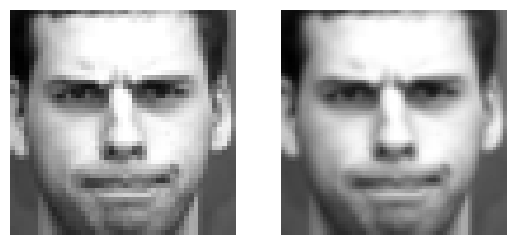

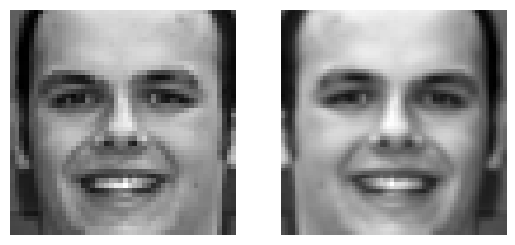

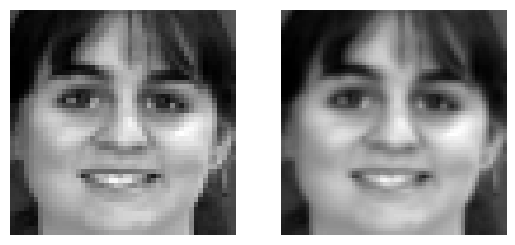

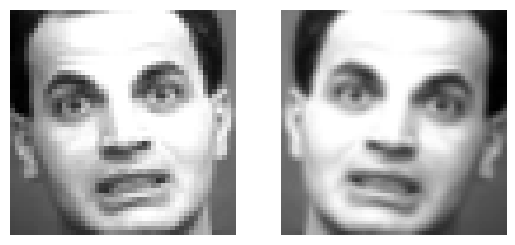

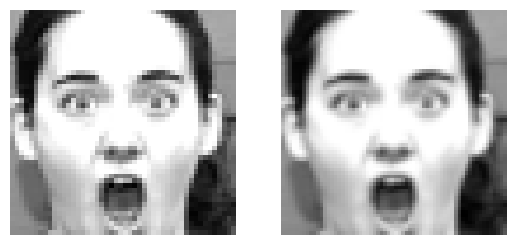

In [43]:
plot_transformed_images(image_path_list,5,train_transforms,42)

In [44]:
#Create a function to take in a dataset
def display_random_images(dataset , classes , n , seed):

  #Setting up random seed
  random.seed(seed)

  #Get random sample indexes
  random_sample_idx = random.sample(range(len(dataset)),k=n)

  #Setting up matplotlib
  plt.figure(figsize=(16,8))

  #set up plot
  for i , targ_sample in enumerate(random_sample_idx):
    targ_image , targ_label = dataset[targ_sample][0] , dataset[targ_sample][1]
    targ_image_adjust = targ_image.permute(1,2,0) # [height,width,color_channels]

    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")

    if classes:
      title = f"Class : {classes[targ_label]}"
      #if display_shape:
        #title = title + f"\nshape : {targ_image_adjust.shape}"
    plt.title(title)


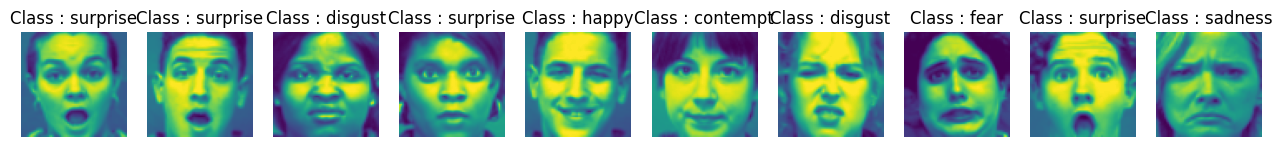

In [45]:
display_random_images(train_data_custom , class_names , 10 , seed = None)

#Creating Training and Testing Function

In [46]:
def train_step(model:torch.nn.Module ,
               dataloader : torch.utils.data.DataLoader ,
               loss_fn , optimizer):

  #Set up reproducability
  torch.manual_seed(42)

  #set into training mode
  model.train()

  #Set up loss and accuracy
  train_loss,train_accuracy = 0,0

  #Loop through dataloader batches
  for batch , (X,y) in enumerate(dataloader):

    #Forward pass
    train_pred = model(X)

    #Loss
    loss = loss_fn(train_pred,y)
    train_loss+=loss.item()

    #Optimizer
    optimizer.zero_grad()

    #Loss.backward()
    loss.backward()

    #optimizer.step()
    optimizer.step()

    #Accuracy
    y_pred_class = torch.argmax(torch.softmax(train_pred,dim=1),dim=1)
    train_accuracy+=(y_pred_class == y).sum().item()/len(y_pred_class)

  train_loss = train_loss / len(dataloader)
  train_accuracy = train_accuracy/len(dataloader)

  return train_loss,train_accuracy

In [56]:
def test_step(model,dataloader,loss_fn):

  #Set up reproducability
  torch.manual_seed(42)

  #Setting into testing mode
  model.eval()

  #Setting up test loss and test accuracy
  test_loss,test_accuracy = 0,0

  with torch.inference_mode():

    for batch , (X,y) in enumerate(dataloader):

    #Forward pass
      test_pred = model(X)

      loss = loss_fn(test_pred,y)
      test_loss+=loss.item()

      #Calculating the accuracy
      y_pred_class = torch.argmax(torch.softmax(test_pred,dim=1),dim=1)
      test_accuracy+= (y == y_pred_class).sum().item()/len(y_pred_class)

  test_loss = test_loss / len(dataloader)
  test_accuracy = test_accuracy/len(dataloader)

  return test_loss,test_accuracy

#Combining test and train Function

In [61]:
def train(model : torch.nn.Module ,train_dataloader : torch.utils.data.DataLoader,
         test_dataloader : torch.utils.data.DataLoader,
         optimizer : torch.optim.Optimizer,
         loss_fn : torch.nn.Module = nn.CrossEntropyLoss(),
         epochs : int = 5):

  results={"train_loss" : [],
           "train_acc" : [],
           "test_loss" : [],
           "test_acc" : []}

  for epoch in tqdm(range(epochs)):

    train_loss,train_acc = train_step(model = model_0 , dataloader = train_dataloader,
                                      loss_fn = loss_fn , optimizer = optimizer)

    test_loss,test_acc = test_step(model=model_0,dataloader = test_dataloader , loss_fn = loss_fn)

    print(f"Epoch : {epoch} | train_loss : {train_loss : .4f} | train_acc : {train_acc*100 : .4f} | test_loss : {test_loss:.4f} | test_acc : {test_acc*100:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

#Train and evaluate Model_0

In [107]:
from tqdm.auto import tqdm
#Setting up reproducability
torch.manual_seed(42)

#Defining epochs
NUM_EPOCHS = 21

model_0 = TinyVGG(input_shape = 1, hidden_units = 10,
                  output_shape = len(class_names))

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_0.parameters(),lr = 0.001)

from timeit import default_timer as timer

start_time = timer()

model_0_results = train(model = model_0 , train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader , optimizer = optimizer,
                        loss_fn = loss_fn , epochs = NUM_EPOCHS)

end_time = timer()

print(f"Total time : {end_time - start_time} sec")

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch : 0 | train_loss :  1.8400 | train_acc :  24.9083 | test_loss : 1.7973 | test_acc : 44.6429
Epoch : 1 | train_loss :  1.6320 | train_acc :  47.8500 | test_loss : 1.4963 | test_acc : 58.4821
Epoch : 2 | train_loss :  1.0881 | train_acc :  67.0750 | test_loss : 0.9869 | test_acc : 65.6250
Epoch : 3 | train_loss :  0.6458 | train_acc :  78.9833 | test_loss : 0.6825 | test_acc : 72.3214
Epoch : 4 | train_loss :  0.4227 | train_acc :  85.2167 | test_loss : 0.6501 | test_acc : 75.4464
Epoch : 5 | train_loss :  0.3146 | train_acc :  90.5000 | test_loss : 0.4725 | test_acc : 81.8452
Epoch : 6 | train_loss :  0.2180 | train_acc :  93.5000 | test_loss : 0.3779 | test_acc : 84.9702
Epoch : 7 | train_loss :  0.1662 | train_acc :  95.7500 | test_loss : 0.3668 | test_acc : 87.2024
Epoch : 8 | train_loss :  0.1307 | train_acc :  96.2500 | test_loss : 0.3627 | test_acc : 88.9881
Epoch : 9 | train_loss :  0.1115 | train_acc :  97.0000 | test_loss : 0.3255 | test_acc : 87.6488
Epoch : 10 | train_l

#Making a DataFrame

In [64]:
import pandas as pd
model_df = pd.DataFrame(model_0_results)

In [65]:
model_df

,train_loss,train_acc,test_loss,test_acc
0,1.840035,0.249083,1.797277,0.446429
1,1.632027,0.478500,1.496285,0.584821
2,1.088128,0.670750,0.986927,0.656250
3,0.645843,0.789833,0.682498,0.723214
4,0.422671,0.852167,0.650145,0.754464
5,0.314603,0.905000,0.472534,0.818452
6,0.217973,0.935000,0.377872,0.849702
7,0.166243,0.957500,0.366753,0.872024
8,0.130720,0.962500,0.362669,0.889881
9,0.111538,0.970000,0.325533,0.876488


#Plotting our prediction

Text(0.5, 1.0, 'Test accuracy')

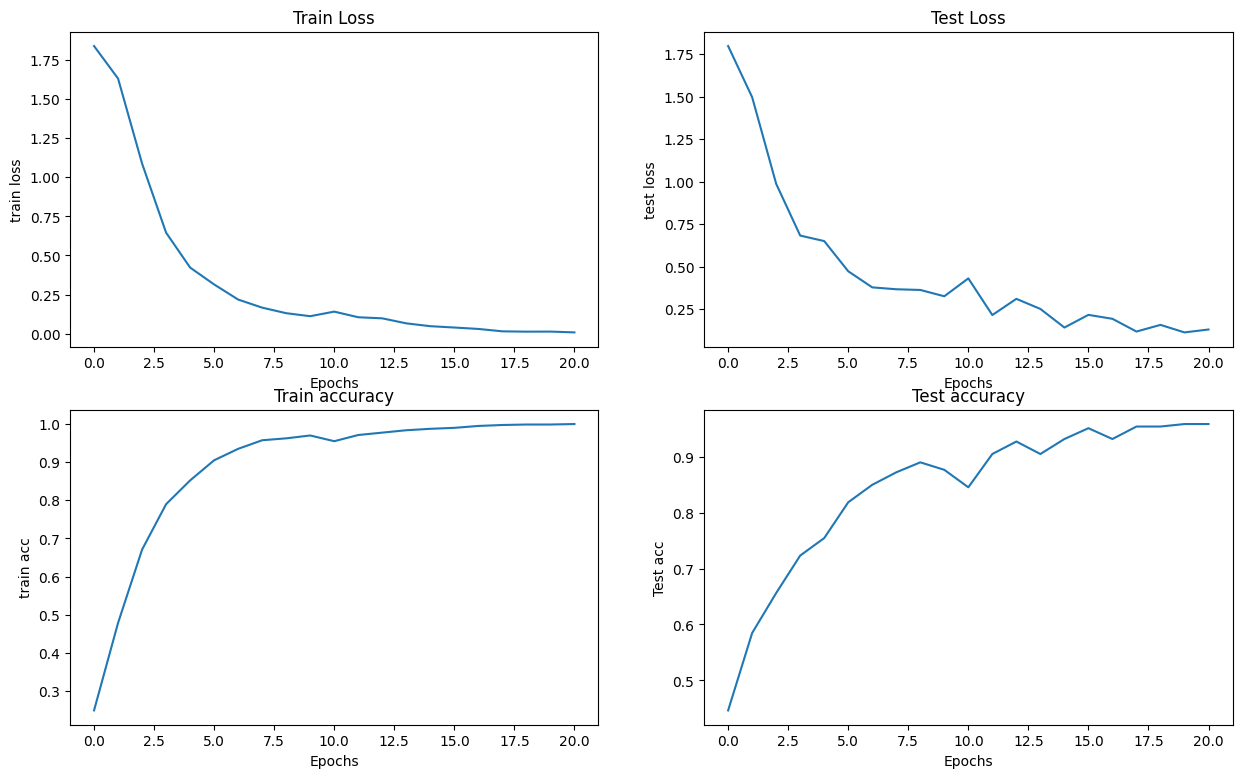

In [68]:
plt.figure(figsize = (15,9))
plt.subplot(2,2,1)
epoch = range(len(model_df))
plt.plot(epoch , model_df["train_loss"])
plt.xlabel("Epochs")
plt.ylabel("train loss")
plt.title("Train Loss")

plt.subplot(2,2,2)
plt.plot(epoch , model_df["test_loss"])
plt.xlabel("Epochs")
plt.ylabel("test loss")
plt.title("Test Loss")

plt.subplot(2,2,3)
plt.plot(epoch , model_df["train_acc"])
plt.xlabel("Epochs")
plt.ylabel("train acc")
plt.title("Train accuracy")

plt.subplot(2,2,4)
plt.plot(epoch , model_df["test_acc"])
plt.xlabel("Epochs")
plt.ylabel("Test acc")
plt.title("Test accuracy")

#Custom Dataset

In [161]:
import torchvision
target_image = torchvision.io.read_image(str("Annie.jpg")).type(torch.float32)/255
target_image

tensor([[[0.3686, 0.3451, 0.3216,  ..., 0.6157, 0.6157, 0.6157],
         [0.3961, 0.3804, 0.3490,  ..., 0.6157, 0.6157, 0.6157],
         [0.4157, 0.4118, 0.3882,  ..., 0.6118, 0.6118, 0.6157],
         ...,
         [0.5176, 0.5216, 0.5294,  ..., 0.4196, 0.4157, 0.4196],
         [0.5098, 0.5137, 0.5216,  ..., 0.4078, 0.4078, 0.4039],
         [0.4980, 0.5020, 0.5098,  ..., 0.4118, 0.4118, 0.4000]],

        [[0.4275, 0.4039, 0.3804,  ..., 0.7255, 0.7255, 0.7255],
         [0.4549, 0.4392, 0.4078,  ..., 0.7255, 0.7255, 0.7255],
         [0.4745, 0.4706, 0.4471,  ..., 0.7294, 0.7294, 0.7255],
         ...,
         [0.2588, 0.2627, 0.2706,  ..., 0.2431, 0.2392, 0.2431],
         [0.2510, 0.2549, 0.2627,  ..., 0.2431, 0.2431, 0.2392],
         [0.2392, 0.2431, 0.2510,  ..., 0.2471, 0.2471, 0.2353]],

        [[0.3373, 0.3137, 0.2980,  ..., 0.6353, 0.6353, 0.6353],
         [0.3647, 0.3490, 0.3255,  ..., 0.6353, 0.6353, 0.6353],
         [0.3922, 0.3882, 0.3647,  ..., 0.6353, 0.6353, 0.

(-0.5, 1200.5, 1599.5, -0.5)

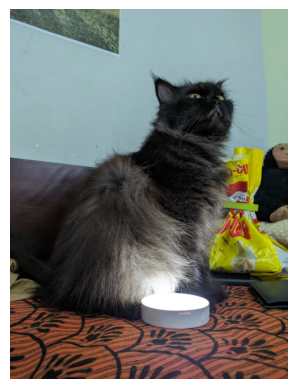

In [162]:
plt.imshow(target_image.permute(1,2,0))
plt.axis("Off")

In [163]:
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.Grayscale(num_output_channels=1)
])

In [164]:
target_image = custom_image_transform(target_image)

In [165]:
model_0 = TinyVGG(input_shape = 1, hidden_units = 10,
                  output_shape = len(class_names))

In [166]:
model_0.eval()

with torch.inference_mode():
  #target_image = target_image.unsqueeze(0)
  target_image_pred = model_0(target_image)

  target_image_prediction_label = torch.argmax(torch.softmax(target_image_pred , dim = 1),dim=1)

  predicted_class_index = target_image_prediction_label[0].item()

  # Get the class label using the index
  predicted_class = class_names[predicted_class_index]

  # Print the predicted class label
  print(f"Predicted class for the image is {predicted_class}")


Predicted class for the image is anger
